In [45]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import imageio
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import binary_erosion, binary_opening
import pandas as pd
import sys
import skimage
sys.path.append("../../")
from VoltageIntensityClass import VoltageIntensity
%matplotlib inline
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func, get_polyfit_func
from alienlab.plot import PlotFigure
extension = ".png"
p = PlotFigure()
p.fonttick = 15
p.fontsize=17

In [46]:
folder_RED = glob.glob("./*autofocus_RED")[0]
print(folder_RED)

folder_BLUE = glob.glob("./*autofocus_BLUE")[0]
print(folder_BLUE)

folder_DRONPA = glob.glob("./*_calib_video*")[0]
print(folder_DRONPA)

.\2022-05-13_14_05_autofocus_RED
.\2022-05-13_14_00_autofocus_BLUE
.\2022-05-13_13_50_D2_calib_video_Dronpa2_DO05


## experimental details

Dissolve in minimal quantity of DMSO (Two-photon Uncaging Acridinone Live-cell (SI)) then in Phosphate Buffer 
(100mM NaCl, 5mM NaOH, 10mM HEPES)
Absorbance max for 15µM: 0.15  
Emission spectrum collected for 15µM solution emission: 690 nm, 8nm width
DDAO and Dronpa sample for video: double glass slide with double-sided tape


Video:  
- Dronpa excited at 480nm to recover the *dispersion of intensity of blue LED spot*   
- DDAO excited at 480nm to recover the *transfert function* of the instrument and to recover the *mean fluorescence intensity from blue excitation* 10 levels of intensity.   
- DDAO excited at 650nm filter 640/20nm dichroic 665nm. From mean fluo level of blue and red excitation, and excitation spectrum: we recover the level of the blue LED. From image: we recover the dispersion of intensity.

# DDAO 15µM

[164891.969] [1288238.5]


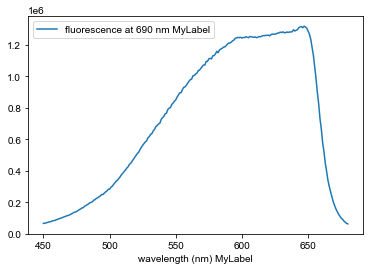

In [47]:
spectrum = pd.read_csv("2022-05-12_12_18_excitation_spectrum_690_DDAO.csv")
headers = spectrum.keys()
spectrum.plot(x = headers[1], y = headers[2])
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])
#plt.figure()µ
#plt.plot(wavelength, fluo)
phi_480 = fluo[wavelength == 480]
phi_640 = fluo[wavelength == 640]
print(phi_480, phi_640)

# Abs Exc

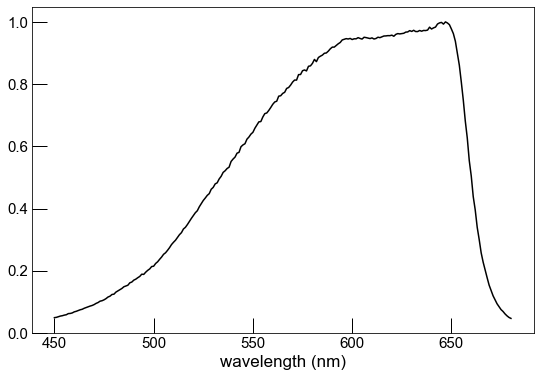

In [48]:
p.xlabel = 'wavelength (nm)'
p.ylabel = ''
fig = p.set_figure(formatx = "%d", formaty = "%0.1f")
spectrum = pd.read_csv("2022-05-12_12_18_excitation_spectrum_690_DDAO.csv")
headers = spectrum.keys()
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])
plt.plot(wavelength, fluo/fluo.max(), "k", label = 'normalized excitation spectrum')
plt.savefig("images/excitation_DDAO_read_690" + extension)

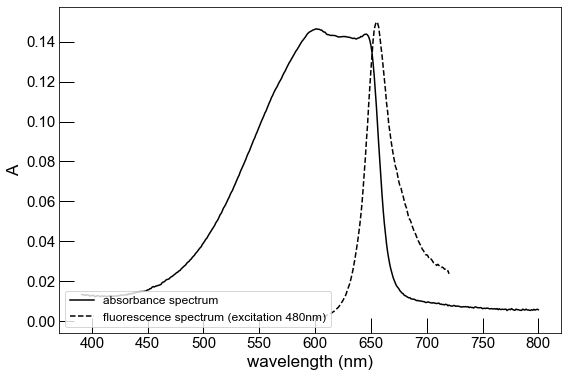

In [49]:
p.xlabel = 'wavelength (nm)'
p.ylabel = 'A'
fig = p.set_figure(formatx = "%d", formaty = "%0.2f")


file= pd.read_csv("DDAO/abs/DDAO_UV.csv", skiprows = [1], skipfooter = 320, sep = ",")
absorbance = np.array(file['Unnamed: 5']) - np.array(file['Unnamed: 3'])
wavelength = np.array(file['DDAO_15uM'])

plt.plot(wavelength, absorbance, "k", label = 'absorbance spectrum')

spectrum = pd.read_csv("2022-06-24_14_26_fluorescence_spectrum_800_DDAO.csv")
headers = spectrum.keys()
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])
plt.plot(wavelength, fluo/fluo.max()*0.15, "k", linestyle="--", label = 'fluorescence spectrum (excitation 480nm)')

plt.legend(prop = {'size':12},  loc = "lower left")
plt.savefig("images/absorbance_fluorescence_DDAO_015uM" + extension)

# Dronpa2 calibration

2264.394720674269


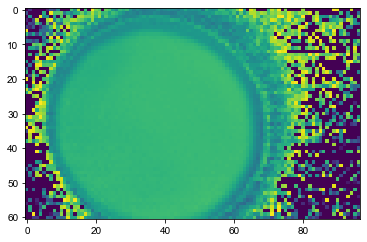

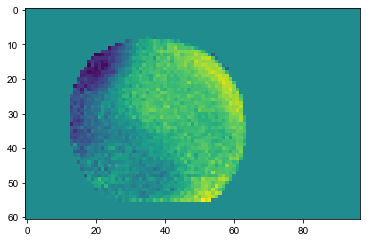

In [50]:
I_480 = np.load(glob.glob(folder_DRONPA + "/*I_480.npy")[0])
plt.imshow(I_480)
plt.figure()
np.median(I_480)
reader = imageio.get_reader(glob.glob(folder_DRONPA + "/video.tiff")[0])
im_read =  reader.get_data(10)
mask_full =im_read>4
mask = downscale_local_mean(mask_full, (10, 10))
mask = mask>0.5
mask = binary_erosion(mask, iterations= 5)
v = I_480*mask
v[v==0]=np.quantile(v, 0.75)
plt.imshow(v)
 
dronpa_480 = np.mean(I_480[mask]) 
print(dronpa_480)

## BLUE

In [51]:
images = glob.glob(folder_BLUE + "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_BLUE + "/voltage.npy")[0]
voltages = np.load(voltages)

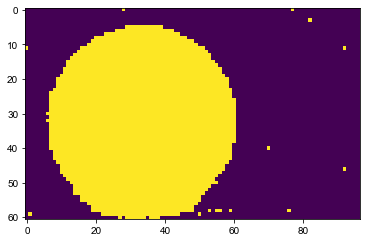

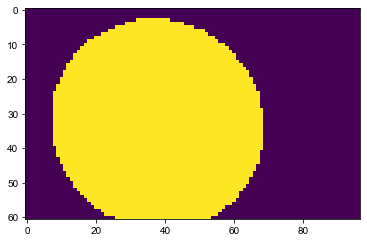

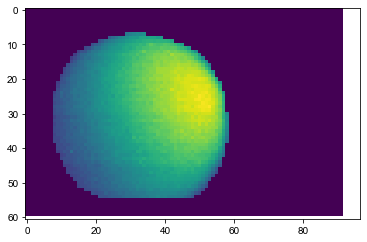

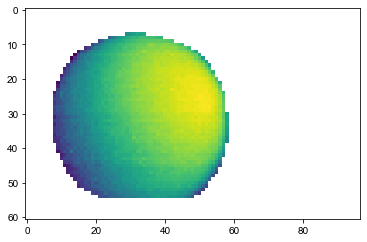

In [52]:
def max_dist(I):
    X = ndi.distance_transform_edt(I)
    x0, y0 = np.unravel_index(X.argmax(), X.shape)
    d0 = np.max(X)
    return x0, y0, d0
    
    
im = images[-1]
im = downscale_local_mean(im, (10, 10))
im_ref = downscale_local_mean(im_read, (10, 10))
plt.figure()
plt.imshow(im>1)
plt.figure()
plt.imshow(im_ref>4)

n=20
im2 = np.copy(im)
im2[im2>n] = n

#shift, error, diffphase = skimage.registration.phase_cross_correlation(im_ref, im, upsample_factor=100)

x0, y0, d0 = max_dist(im>1) #1
x1, y1, d1 = max_dist(im_ref>4)

shift = [y1 - y0, x1 - x0]
tform = skimage.transform.AffineTransform(translation = shift)

I_480_t = skimage.transform.warp(I_480, tform)
transfert = im / I_480_t

mask_t = skimage.transform.warp(mask, tform)
plt.figure()
plt.imshow(transfert*mask_t)
plt.figure()
plt.imshow(np.log(transfert*mask_t))
plt.savefig('images/transfert_function_690nm' + extension)

## Fourier transfert

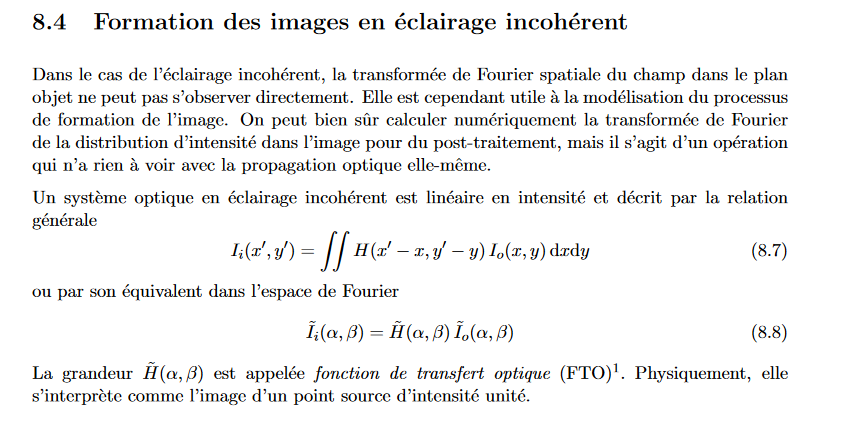

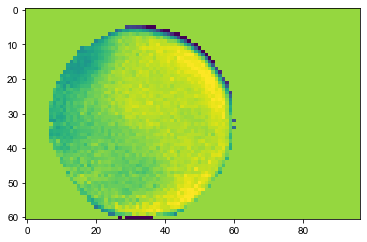

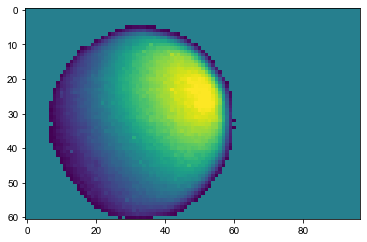

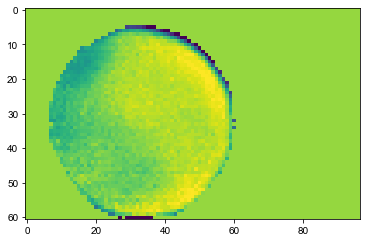

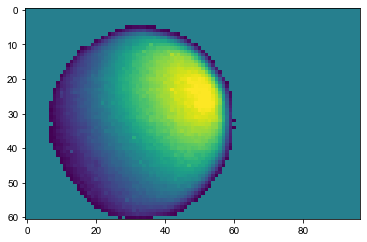

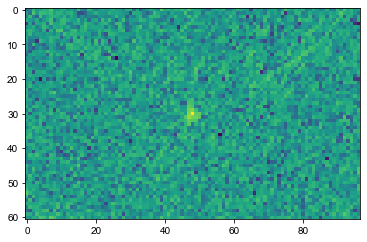

In [53]:
from scipy.fftpack import fft2
from scipy.fftpack import ifft2

from numpy.fft import fftshift, ifftshift

from scipy.fftpack import fft2 as fft
from numpy.fft import fftshift, ifftshift

def crop_outliers(X, q1=0.01, q3=0.99):

    Q1 = np.quantile(X, q1)
    Q3 = np.quantile(X, q3)
    X[X<Q1]=Q1
    X[X>Q3]=Q3
    return X

def prepare_input(X, mask):
    Im = np.copy(X)
    Im[mask] = crop_outliers(Im[mask]) 

    Im = Im*mask
    Im[Im==0] = np.median(Im[mask])
    return Im

im = np.mean(images[4:-1], axis = 0)
im = downscale_local_mean(im, (10, 10))

maskim = im>1
maskim = binary_opening(maskim)

I0 = prepare_input(I_480_t, maskim)
Icam = prepare_input(im, maskim)
plt.figure()
plt.imshow(I0)

plt.figure()
plt.imshow(Icam)

#iFI0 = crop_outliers(1/fft2(I0))
#FIcam = crop_outliers(fft2(Icam))
#transfert_fourier = crop_outliers(FIcam*iFI0)
iF0 = 1/fft2(I0)
FIcam = fft2(Icam)
transfert_fourier = crop_outliers(FIcam*iF0, 0.001, 0.999)

def make_transfert(Icam):
    FIcam = fft2(Icam)
    FI0 = FIcam/transfert_fourier
    I0 = ifft2(FI0)
    return np.abs(I0)

plt.figure()
plt.imshow(make_transfert(Icam))
plt.figure()
plt.imshow(Icam)

"""


FI0 = fft2(I0)
F_F = ifft2(FI0)

fig, axs = plt.subplots(1,3,figsize=(12, 4))
axs[0].imshow(I0)
axs[1].imshow(np.abs(FI0))
axs[2].imshow(np.abs(F_F))



plt.figure()

T = ifft2(transfert)
plt.imshow(np.abs(T))

transfert_fourier = np.copy(transfert)


FIcam2 = FI0*transfert_fourier
plt.figure()
plt.imshow(np.abs(ifft2((FIcam2))))

FI02 = FIcam/transfert_fourier

plt.figure()
plt.imshow(np.abs(ifft2((FI02))))
"""




plt.figure()



plt.imshow(np.log(np.abs(fftshift(ifft2(transfert_fourier)))))
    

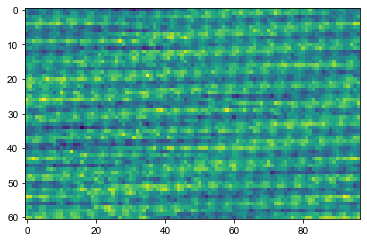

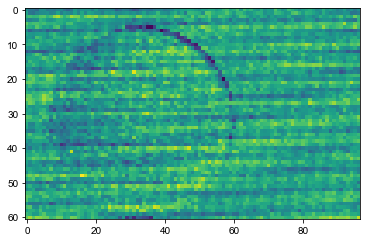

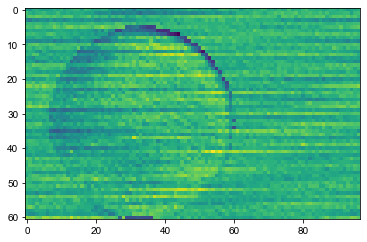

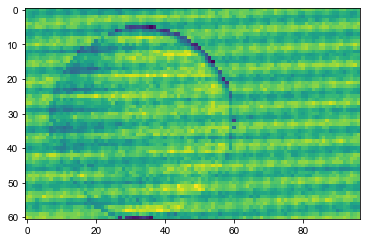

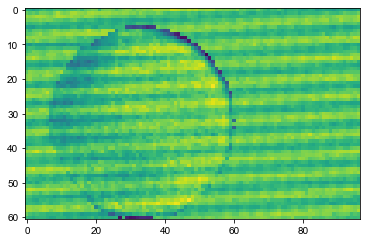

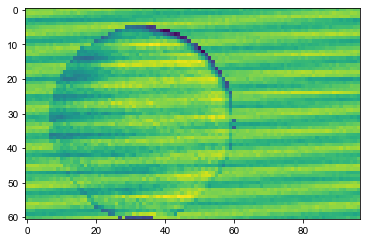

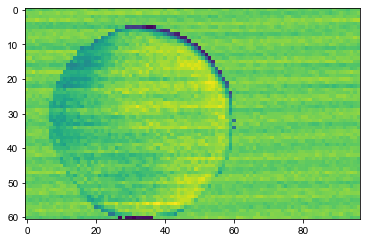

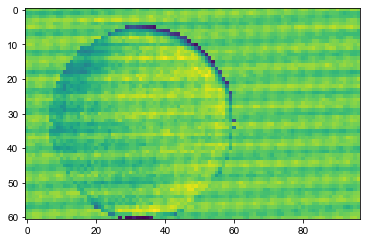

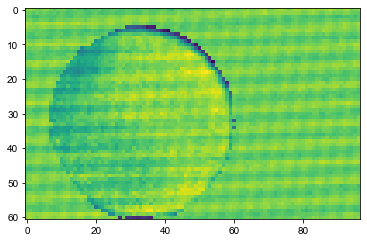

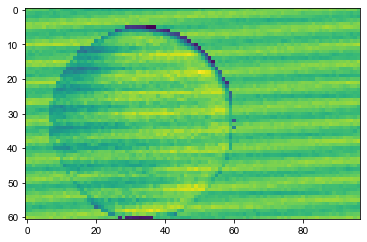

In [54]:
images = glob.glob(folder_BLUE+ "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_BLUE + "/voltage.npy")[0]
voltages = np.load(voltages)
for image in images:
    im = downscale_local_mean(image, (10, 10))
    im = prepare_input(im, maskim)
    
    plt.figure()
    v = make_transfert(im)
    #v = v*mask_t
    #v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)

In [55]:
mean_480 = []

for i in range(9):
    im = downscale_local_mean(images[i], (10, 10))
    v = im/transfert*mask
    v[v==0]=np.quantile(v, 0.75)
    mean_480.append(np.mean(im[mask]))
    if False:
        plt.figure()
        plt.imshow(v)

mean_480 =np.array(mean_480)

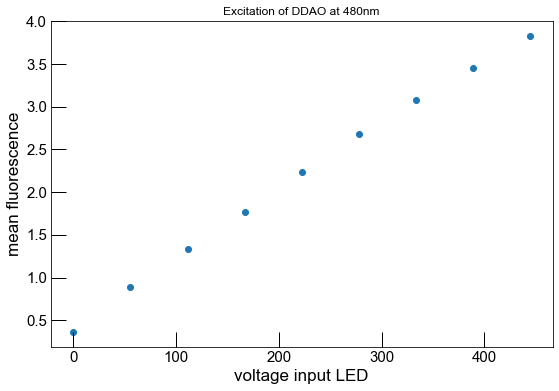

In [56]:
fig = p.set_figure("%d", "%0.1f")
plt.scatter(voltages[:-1], mean_480)
plt.xlabel("voltage input LED")
plt.ylabel("mean fluorescence")
plt.title("Excitation of DDAO at 480nm")

plt.savefig("images/excitation_ddao_480_various_intensities" + extension)

# RED

In [57]:
images = glob.glob(folder_RED + "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_RED + "/voltage.npy")[0]
voltages = np.load(voltages)

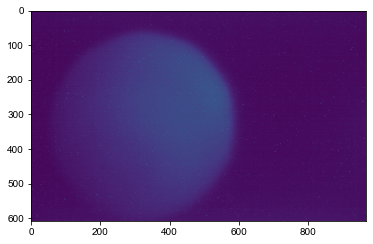

In [58]:
im = np.sum(images, axis = 0)
n=150
im[im>n] = n
plt.imshow(im)

In [59]:
mean_640 = []

for i in range(9):
    im = downscale_local_mean(images[i], (10, 10))
    v = im/transfert*mask
    v[v==0]=np.quantile(v, 0.75)
    mean_640.append(np.mean(im[mask]))
    if False:
        plt.figure()
        plt.imshow(v)
mean_640 = np.array(mean_640)

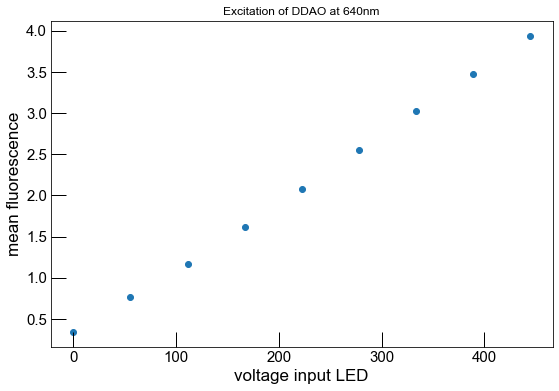

In [60]:
fig = p.set_figure("%d", "%0.1f")
plt.scatter(voltages[:-1], mean_640)
plt.xlabel("voltage input LED")
plt.ylabel("mean fluorescence")
plt.title("Excitation of DDAO at 640nm")

plt.savefig("images/excitation_ddao_640_various_intensities" + extension)

Text(0, 0.5, 'meanfluo')

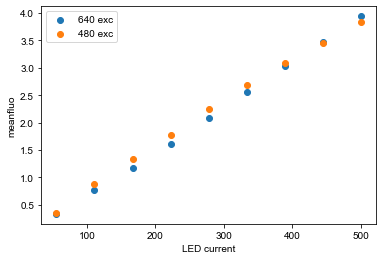

In [61]:
plt.scatter(voltages[1:], mean_640, label = '640 exc')
plt.scatter(voltages[1:], mean_480, label = '480 exc')
plt.legend()
plt.xlabel("LED current")
plt.ylabel("meanfluo")

In [62]:
V = VoltageIntensity(folder = "2022-05-13_10_41_bode_diagram_DRONPA2")

2022-05-13_10_41_bode_diagram_DRONPA2


In [63]:

dict_amplitude = {
    0: 0,
    55:1.3,
    111:2.6,
    166:3.8,
    222:5.1,
    277:6.4,
    333:7.6,
    388:8.8,
    444:10,}

S = 0.25*d0/d1
def dict_to_func(dict_amplitude):
    x = []
    y = []
    for k in dict_amplitude.keys():
        x.append(k)
        y.append(dict_amplitude[k])
    x = np.array(x)
    y = np.array(y)
    func = get_affine_func(x, y)
    return func
    
def amp_to_eins(dict_amplitude, amplitude):
    #ref: https://fr.wikipedia.org/wiki/Einstein_(unit%C3%A9_de_mesure)
    func = dict_to_func(dict_amplitude)
    power = func(amplitude)
    eins=power*1e-3*1e3*640/120/S
    
    return eins*1.298/1.137


0.0 -52.77590099234571
55.55555555555556 338.31267111312195
111.11111111111111 707.88866590998
166.66666666666669 1055.4381463585464
222.22222222222223 1380.4810686461915
277.77777777777777 1682.5712821873394
333.33333333333337 1961.2965296234674
388.8888888888889 2216.278446823105
444.44444444444446 2447.1725628818363


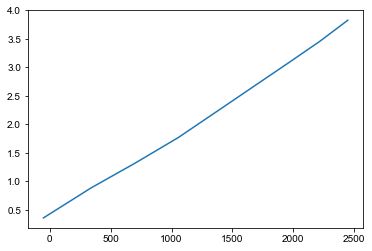

In [64]:
blues = []
for i in range(9):
    intensity_blue = V.get_intensity_voltage("blue", 0.5, voltages[i]/100) * dronpa_480 / ( V.get_intensity_voltage("blue", 0.5, 400/100))
    print(voltages[i], intensity_blue)
    blues.append(intensity_blue)
plt.plot(blues, mean_480)
blues = np.array(blues)

intnsity predicted 292.3650382628764
intensity MPPC 245.17257974917254


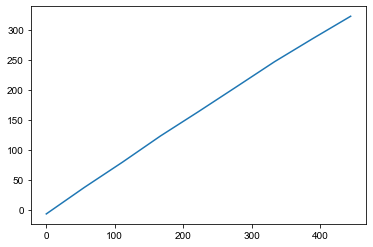

In [65]:
reds = blues * mean_640/mean_480 * phi_480/phi_640
plt.figure()
plt.plot(voltages[:-1], reds)

func = get_polyfit_func(voltages[:-1], reds, 2)

print("intnsity predicted", func(400))
print("intensity MPPC", amp_to_eins(dict_amplitude, 400))

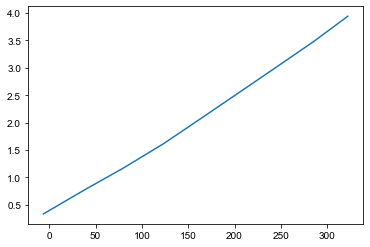

In [66]:
plt.plot(reds, mean_640)

## Heterogeneity auto-test blue

In [67]:
images = glob.glob(folder_BLUE+ "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_BLUE + "/voltage.npy")[0]
voltages = np.load(voltages)

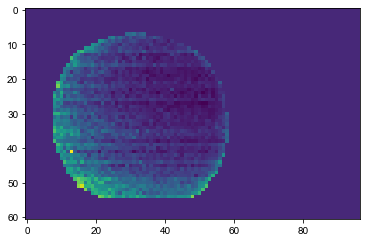

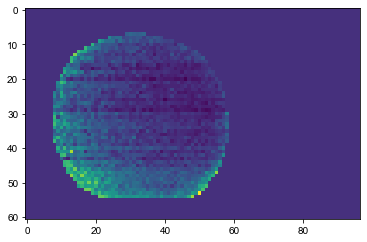

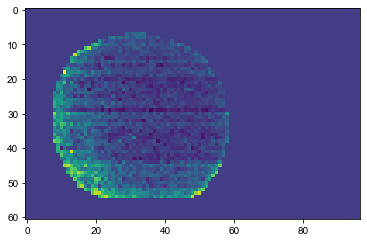

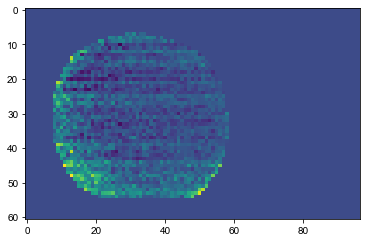

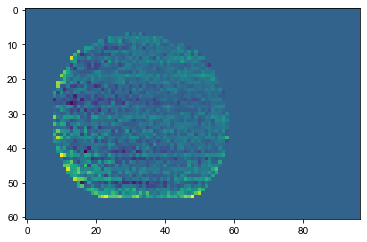

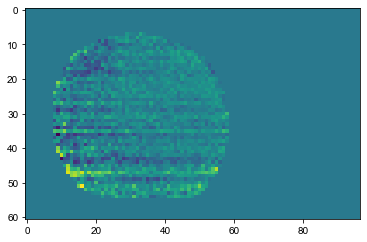

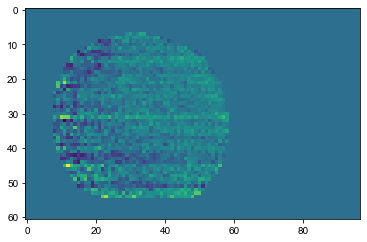

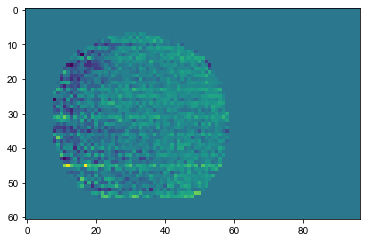

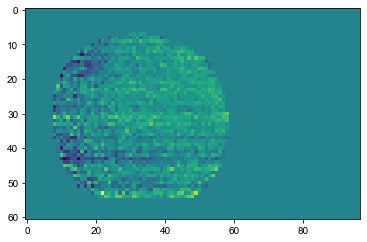

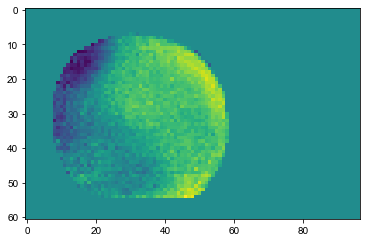

In [68]:
for image in images:
    plt.figure()
    im = downscale_local_mean(image, (10, 10))
    v = im/transfert*mask_t
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)

## Fourier

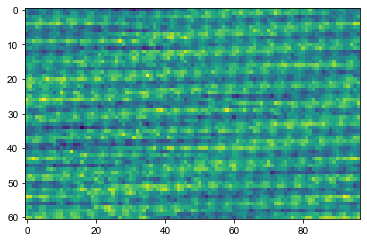

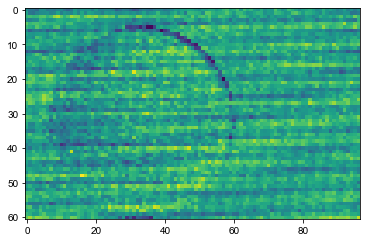

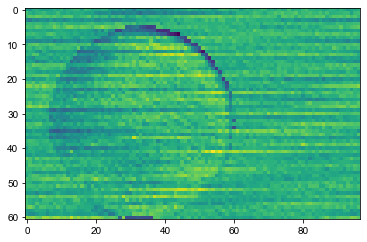

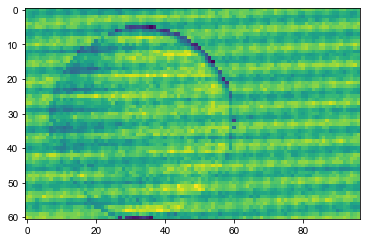

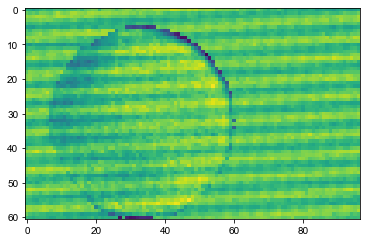

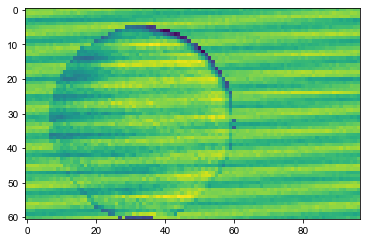

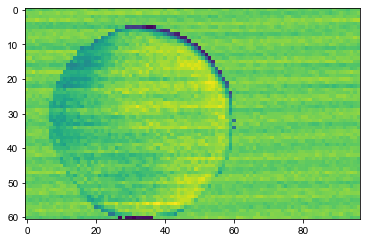

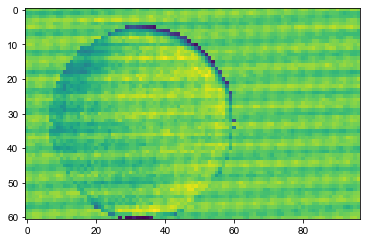

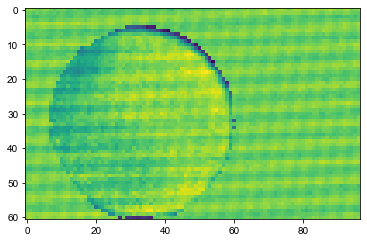

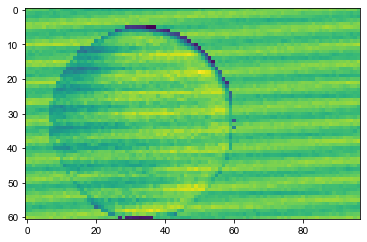

In [69]:
for image in images:
    plt.figure()
    im = downscale_local_mean(image, (10, 10))
    im = prepare_input(im, maskim)
    
    v = make_transfert(im)
    v = v#*mask_t
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)

## Heterogeneity red

In [70]:
images = glob.glob(folder_RED+ "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_RED + "/voltage.npy")[0]
voltages = np.load(voltages)

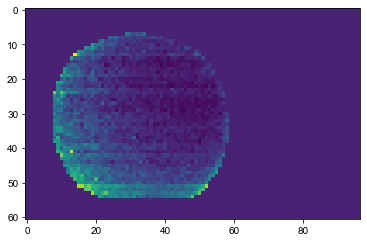

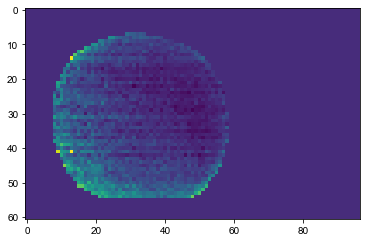

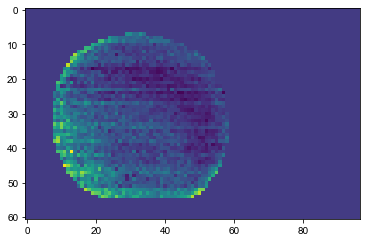

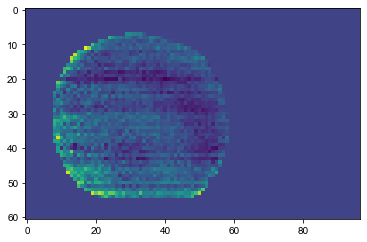

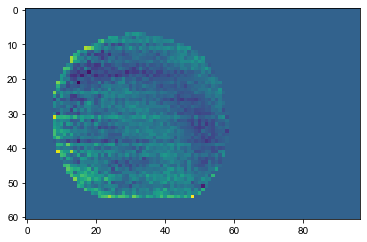

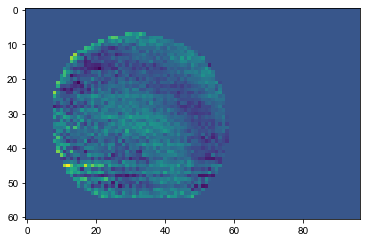

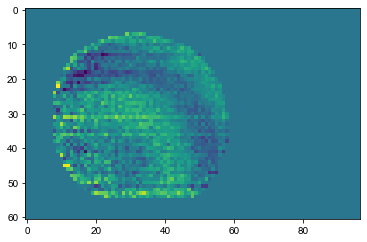

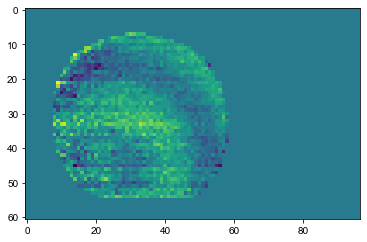

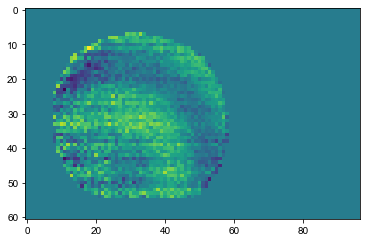

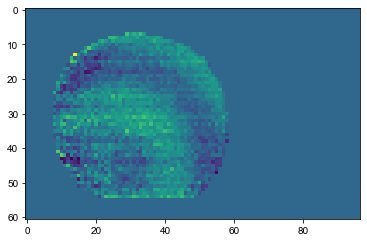

In [71]:
for image in images:
    plt.figure()
    im = downscale_local_mean(image, (10, 10))
    #plt.imshow(im)
    v = im/transfert*mask_t
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)
    plt.savefig("images/airy_red_LED"+ extension)

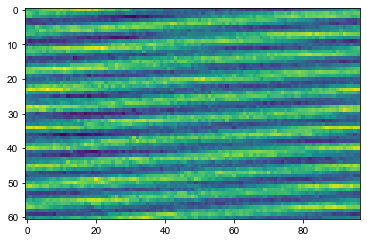

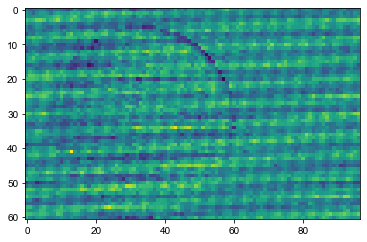

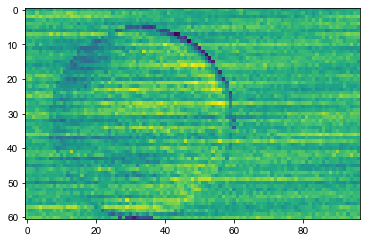

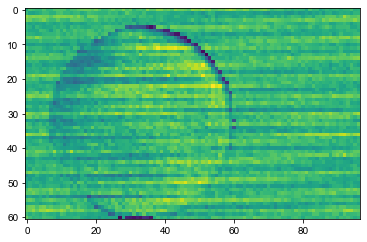

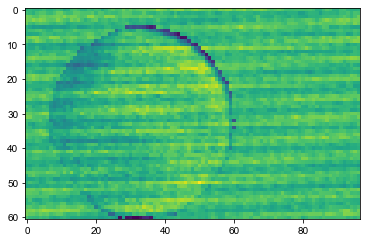

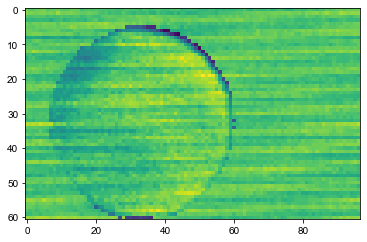

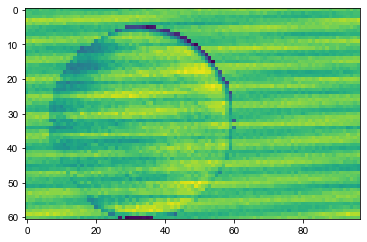

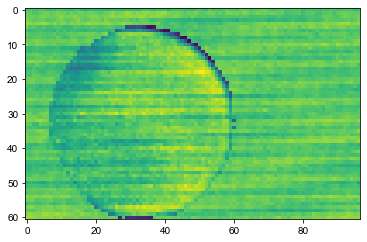

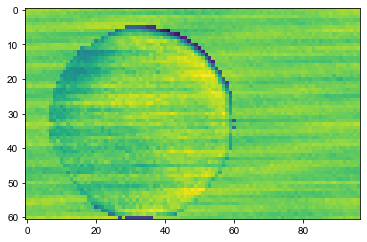

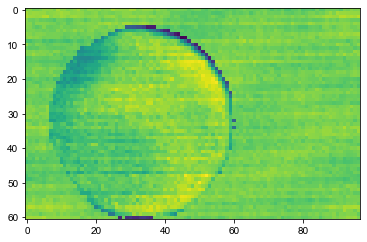

In [36]:
for image in images:
    plt.figure()
    
    im = downscale_local_mean(image, (10, 10))
    im = prepare_input(im, maskim)

    v = make_transfert(im)
    v = v#*binary_erosion(mask_t, iterations=3)
    #v = im/transfert*maskim
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)

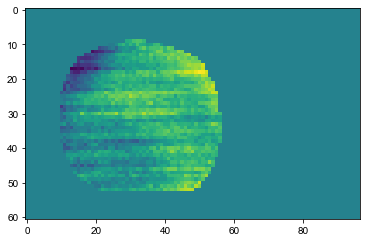

In [37]:
images = glob.glob(folder_RED+ "/images.npy")[0]
images = np.load(images)
image = np.mean(images[6:-1], axis = 0)    
im = downscale_local_mean(image, (10, 10))
im = prepare_input(im, maskim)

v = make_transfert(im)
v = v*binary_erosion(mask_t, iterations=2)
#v = im/transfert*maskim
v[v==0] = np.quantile(v, 0.75)
plt.imshow(v)

In [38]:
images = glob.glob(folder_RED+ "/images.npy")[0]
images = np.load(images)
imagered = np.mean(images[4:-1], axis = 0)  

images = glob.glob(folder_BLUE+ "/images.npy")[0]
images = np.load(images)
imageblue = np.mean(images[4:-1], axis = 0)  

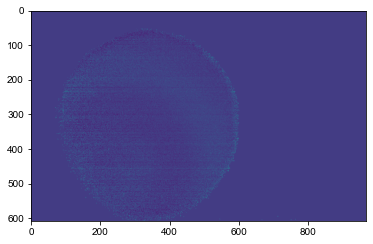

In [39]:
plt.figure()
maski = (binary_opening(imageblue>1)==0)
imageblue[maski] = np.median(imageblue[1-maski])
imagered[maski] = np.median(imagered[1-maski])
x = imageblue/imagered
x[x==np.inf] = np.median(x[maski])
x[x!=x] = np.median(x[maski])
x[1-maski] = np.median(x[maski])

plt.imshow(x)

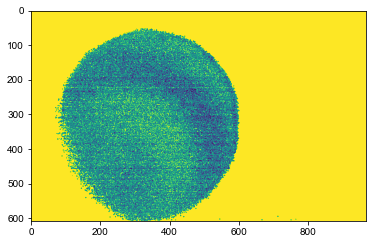

In [40]:
x[x>1] = 0.5
plt.imshow(x)

(array([9.53530e+04, 1.09000e+02, 5.24000e+02, 1.73800e+03, 2.95100e+03,
        6.78500e+03, 1.09950e+04, 2.01430e+04, 2.60170e+04, 4.23929e+05]),
 array([0.46153846, 0.51538462, 0.56923077, 0.62307692, 0.67692308,
        0.73076923, 0.78461538, 0.83846154, 0.89230769, 0.94615385,
        1.        ]),
 <BarContainer object of 10 artists>)

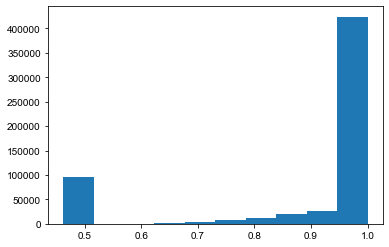

In [41]:
plt.hist(x.flatten())